In [1]:
import numpy as np
import torch
import torchvision.transforms as T
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision

# Helper Functions

In [2]:
def show_image(img):
    plt.figure(figsize=(5,5));
    plt.imshow(img, cmap="gray");
    plt.axis("off");

In [3]:
def get_stats(ds):
    """ Computes mean and std for the dataset
    """
    train_loader = DataLoader(ds,
                          batch_size=50000, # full set of images
                          num_workers=4,
                          shuffle=True,
                          pin_memory=True)
    for  batch in train_loader:
        break
    ds_np = np.array(batch[0], dtype = np.float64)
    mean = np.mean(ds_np, dtype=np.float64)
    cov = np.cov(ds_np.reshape(ds_np.shape[1],ds_np.shape[0]))
    var = ds_np.var(axis=0, dtype=np.float64)
    return mean, cov, var

In [4]:
def get_noisy_batch(batch, cov):
    noisy_samples = []
    for i in range(batch.shape[0]):
        xt = batch[i,...]
        noisy_dist = torch.distributions.multivariate_normal.MultivariateNormal(xt, cov)
        noisy_samples.append(noisy_dist.sample())
    return torch.stack(noisy_samples)

In [5]:
def get_ori_ds(ds):
    """ Computes mean and std for the dataset
    """
    train_loader = DataLoader(ds,
                          batch_size=50000, # full set of images
                          num_workers=4,
                          shuffle=True,
                          pin_memory=True)
    for  batch in train_loader:
        break
    return batch[0]

# Dataset

In [6]:
train_tfms = T.Compose([
    T.RandomCrop((28,28)),
    T.Grayscale(),
    T.ToTensor(),
    T.Lambda(lambda x: x.view(x.shape[1]**2)) # reshaping for our input shape
])

In [7]:
ds = torchvision.datasets.CIFAR10(root = "../data/", 
                                  train = True, 
                                  transform  = train_tfms, 
                                  target_transform = None, 
                                  download = False)

In [8]:
ori_loader = DataLoader(ds,
                        batch_size=2,
                        num_workers=4,
                        shuffle=True,
                        pin_memory=True)

In [9]:
mean, cov, var = get_stats(ds)

In [10]:
def whitening_ds(ds, covariance_matrix, mean, epsilon=1e-5):
    mean = torch.from_numpy(np.array(mean))
    U,S,V = np.linalg.svd(covariance_matrix)
    zca = np.dot(U, np.dot(np.diag(1.0/np.sqrt(S + epsilon)), U.T))
    return (torch.from_numpy(zca).double() @ (ds.T - mean).double()).permute(1,0)

In [11]:
def get_ds_whitened(ds):
    """ Computes mean and std for the dataset
    """
    train_loader = DataLoader(ds,
                          batch_size=50000, # full set of images
                          num_workers=4,
                          shuffle=True,
                          pin_memory=True)
    for  batch in train_loader:
        break
    whitened_ds = whitening_ds(batch[0], cov, mean, epsilon=1e-5)

    return whitened_ds

In [12]:
whitened_ds = get_ds_whitened(ds)

# cNCE Loss Function

In [13]:
def cnce_loss(xt, yt):
    """ Computes the cNCE loss function:
    inputs:
        - precision matrix
    """
    def cmpt_g(xt, yt):
        log_phi_xt = model(xt)
        log_phi_yt = model(yt)
        st = torch.stack((log_phi_xt, log_phi_yt), dim = 1)
        return log_phi_xt, st

    log_phi_xt, st = cmpt_g(xt, yt)
    loss = log_phi_xt - torch.logsumexp(st, dim = 1)
    loss = loss.mean()
    return  -loss

### Covar for the Noisy Dist

In [14]:
covariance_noise = torch.from_numpy(np.diag(var / 100))

# DEM 

In [47]:
class DeepEBM(torch.nn.Module):
    def __init__(self, std, k, normalizer = torch.tensor(-1000.0, dtype = torch.float64)):
        super(DeepEBM,self).__init__()
        self.std = std
        self.in_feat = 784
        self.out_feat = k
        self.V = torch.nn.Parameter(torch.empty((self.out_feat, self.in_feat), dtype = torch.float64))
        self.W = torch.nn.Parameter(torch.empty((self.out_feat, self.out_feat), dtype = torch.float64))
        self.b = torch.nn.Parameter(torch.empty((self.in_feat, 1), dtype = torch.float64))
        self.c = torch.nn.Parameter(torch.empty((self.out_feat, 1), dtype = torch.float64))
        self.S = torch.nn.Softplus()
        self.s = torch.nn.Sigmoid()
        self.normalizer = torch.nn.Parameter(normalizer)
        torch.nn.init.normal_(self.V, mean =0.0, std=0.01)
        torch.nn.init.normal_(self.W, mean =0.0, std=0.01)
        torch.nn.init.normal_(self.b, mean =0.0, std=0.01)
        torch.nn.init.normal_(self.c, mean =0.0, std=0.01)

        
    def forward(self,x):
        g_theta_x = self.s(self.V @ x.permute(1,0))
        a = torch.sum(self.S(self.W.T @ g_theta_x + self.c), dim = 0).reshape(1, -1)
        b_ = self.b.T @ x.permute(1,0)
        c_ = (- 0.5 * (1 / self.std**2) * torch.norm(x, dim = 1)**2).reshape(1, -1)
        log_ptheta = c_ + b_ + a
        return (-log_ptheta + self.normalizer)

In [48]:
model = DeepEBM(1.0, 64)

# Optimizer Initialization

In [49]:
optim = torch.optim.Adam(model.parameters(), lr=1e-2)

# Training

In [50]:
whitenings_ds = True

In [51]:
if whitenings_ds:
    ori_ds = whitened_ds
else:
    ori_ds = get_ori_ds(ds)

In [52]:
batch_size = 1000

In [53]:
epochs = 20

In [54]:
for epoch in range(epochs):
    total_loss = 0
    random_ds=ori_ds[torch.randperm(ori_ds.shape[0])] #shuffle
    for i in range(int(ori_ds.shape[0]/batch_size)):
        optim.zero_grad()

        batch = random_ds[i*batch_size:(i+1)*batch_size,...]
        batch = batch.double()
        noisy_batch = get_noisy_batch(batch, covariance_noise)
        loss = cnce_loss(batch, noisy_batch)

        loss.backward()
        print(f"Epoch {epoch}/It.{i}   Loss:{loss.detach().item()}")
        total_loss += loss.detach().item()
        optim.step()
    print(f"Avg: Epoch {epoch}   Loss:{total_loss/(ori_ds.shape[0]/batch_size)}")

Epoch 0/It.0   Loss:0.9063180935412133
Epoch 0/It.1   Loss:0.8973387244255107
Epoch 0/It.2   Loss:0.90634307730547
Epoch 0/It.3   Loss:0.892654981196533
Epoch 0/It.4   Loss:0.9272841534984795
Epoch 0/It.5   Loss:0.8947698833188956
Epoch 0/It.6   Loss:0.868204951415956
Epoch 0/It.7   Loss:0.9012046508331792
Epoch 0/It.8   Loss:0.8806691112739811
Epoch 0/It.9   Loss:0.9091840204887832
Epoch 0/It.10   Loss:0.9253607030977509
Epoch 0/It.11   Loss:0.8806878257531686
Epoch 0/It.12   Loss:0.9082091315632926
Epoch 0/It.13   Loss:0.9363717781136539
Epoch 0/It.14   Loss:0.8792207814627853
Epoch 0/It.15   Loss:0.9209348489693556
Epoch 0/It.16   Loss:0.8984552013491748
Epoch 0/It.17   Loss:0.9119489675688743
Epoch 0/It.18   Loss:0.8986128374214878
Epoch 0/It.19   Loss:0.909943221812237
Epoch 0/It.20   Loss:0.8933671673610136
Epoch 0/It.21   Loss:0.864227559837806
Epoch 0/It.22   Loss:0.902060876941762
Epoch 0/It.23   Loss:0.8955798532498135
Epoch 0/It.24   Loss:0.9181993340901329
Epoch 0/It.25   L

Epoch 4/It.3   Loss:0.8846444273523072
Epoch 4/It.4   Loss:0.8778889193734912
Epoch 4/It.5   Loss:0.849846113365765
Epoch 4/It.6   Loss:0.9188622759039304
Epoch 4/It.7   Loss:0.8838162558431133
Epoch 4/It.8   Loss:0.9108251470739672
Epoch 4/It.9   Loss:0.8846073204117755
Epoch 4/It.10   Loss:0.9054891653119969
Epoch 4/It.11   Loss:0.883380113760124
Epoch 4/It.12   Loss:0.9103420422816123
Epoch 4/It.13   Loss:0.8899779027621826
Epoch 4/It.14   Loss:0.9107525634265925
Epoch 4/It.15   Loss:0.865873258644029
Epoch 4/It.16   Loss:0.9027106806089636
Epoch 4/It.17   Loss:0.869704778967734
Epoch 4/It.18   Loss:0.898921015424421
Epoch 4/It.19   Loss:0.9140450063865702
Epoch 4/It.20   Loss:0.9164679103698832
Epoch 4/It.21   Loss:0.8929907264275652
Epoch 4/It.22   Loss:0.8767181631692441
Epoch 4/It.23   Loss:0.907346478370919
Epoch 4/It.24   Loss:0.9265550291627569
Epoch 4/It.25   Loss:0.9034140295532016
Epoch 4/It.26   Loss:0.906665880512188
Epoch 4/It.27   Loss:0.9035457440017504
Epoch 4/It.28 

Epoch 8/It.6   Loss:0.8925014320032947
Epoch 8/It.7   Loss:0.8806841895103423
Epoch 8/It.8   Loss:0.8876492181162753
Epoch 8/It.9   Loss:0.8829599212013123
Epoch 8/It.10   Loss:0.9103741674743693
Epoch 8/It.11   Loss:0.8824977531026674
Epoch 8/It.12   Loss:0.8799030695724325
Epoch 8/It.13   Loss:0.9011006993742824
Epoch 8/It.14   Loss:0.8796493855402173
Epoch 8/It.15   Loss:0.8802988302958541
Epoch 8/It.16   Loss:0.8813956241315737
Epoch 8/It.17   Loss:0.9069226069108478
Epoch 8/It.18   Loss:0.8913536417007615
Epoch 8/It.19   Loss:0.895480619489149
Epoch 8/It.20   Loss:0.9000410482520358
Epoch 8/It.21   Loss:0.8952175542741347
Epoch 8/It.22   Loss:0.8931901727810352
Epoch 8/It.23   Loss:0.9057990491360539
Epoch 8/It.24   Loss:0.8720614102719838
Epoch 8/It.25   Loss:0.907984104833419
Epoch 8/It.26   Loss:0.8951836205941567
Epoch 8/It.27   Loss:0.8899130774638018
Epoch 8/It.28   Loss:0.892107170389612
Epoch 8/It.29   Loss:0.8976618461717856
Epoch 8/It.30   Loss:0.8848070351986908
Epoch 8

Epoch 12/It.6   Loss:0.8855208492514022
Epoch 12/It.7   Loss:0.9221415582461198
Epoch 12/It.8   Loss:0.907125019764602
Epoch 12/It.9   Loss:0.9093327484439228
Epoch 12/It.10   Loss:0.8856936020274587
Epoch 12/It.11   Loss:0.8972952273760857
Epoch 12/It.12   Loss:0.9219827227539308
Epoch 12/It.13   Loss:0.915315452026756
Epoch 12/It.14   Loss:0.881256818457631
Epoch 12/It.15   Loss:0.9046615186854136
Epoch 12/It.16   Loss:0.8929594396482139
Epoch 12/It.17   Loss:0.8682635375996202
Epoch 12/It.18   Loss:0.8842004217544841
Epoch 12/It.19   Loss:0.9313255844320529
Epoch 12/It.20   Loss:0.9006444231607468
Epoch 12/It.21   Loss:0.9287915861823977
Epoch 12/It.22   Loss:0.8930039909824925
Epoch 12/It.23   Loss:0.8976208392698144
Epoch 12/It.24   Loss:0.8872073936746323
Epoch 12/It.25   Loss:0.8964812584424351
Epoch 12/It.26   Loss:0.8636735983803284
Epoch 12/It.27   Loss:0.8778405449415533
Epoch 12/It.28   Loss:0.8995120203802173
Epoch 12/It.29   Loss:0.8915532346031761
Epoch 12/It.30   Loss:0

Epoch 16/It.4   Loss:0.8903938110990118
Epoch 16/It.5   Loss:0.8981671967754126
Epoch 16/It.6   Loss:0.8972535704813316
Epoch 16/It.7   Loss:0.8904988194902476
Epoch 16/It.8   Loss:0.883230472124107
Epoch 16/It.9   Loss:0.8962172139179769
Epoch 16/It.10   Loss:0.9187684123981573
Epoch 16/It.11   Loss:0.8900811957642762
Epoch 16/It.12   Loss:0.8835697709406861
Epoch 16/It.13   Loss:0.907635839949332
Epoch 16/It.14   Loss:0.8723681302648999
Epoch 16/It.15   Loss:0.9163736717617693
Epoch 16/It.16   Loss:0.9048489151601918
Epoch 16/It.17   Loss:0.8871516202519573
Epoch 16/It.18   Loss:0.8839649119728255
Epoch 16/It.19   Loss:0.8829530695293791
Epoch 16/It.20   Loss:0.9010237341135411
Epoch 16/It.21   Loss:0.9153094191598955
Epoch 16/It.22   Loss:0.8985098254457056
Epoch 16/It.23   Loss:0.8917425285136886
Epoch 16/It.24   Loss:0.8986634196020475
Epoch 16/It.25   Loss:0.8833794915260612
Epoch 16/It.26   Loss:0.8913449450597939
Epoch 16/It.27   Loss:0.9031245866686902
Epoch 16/It.28   Loss:0.

# Results

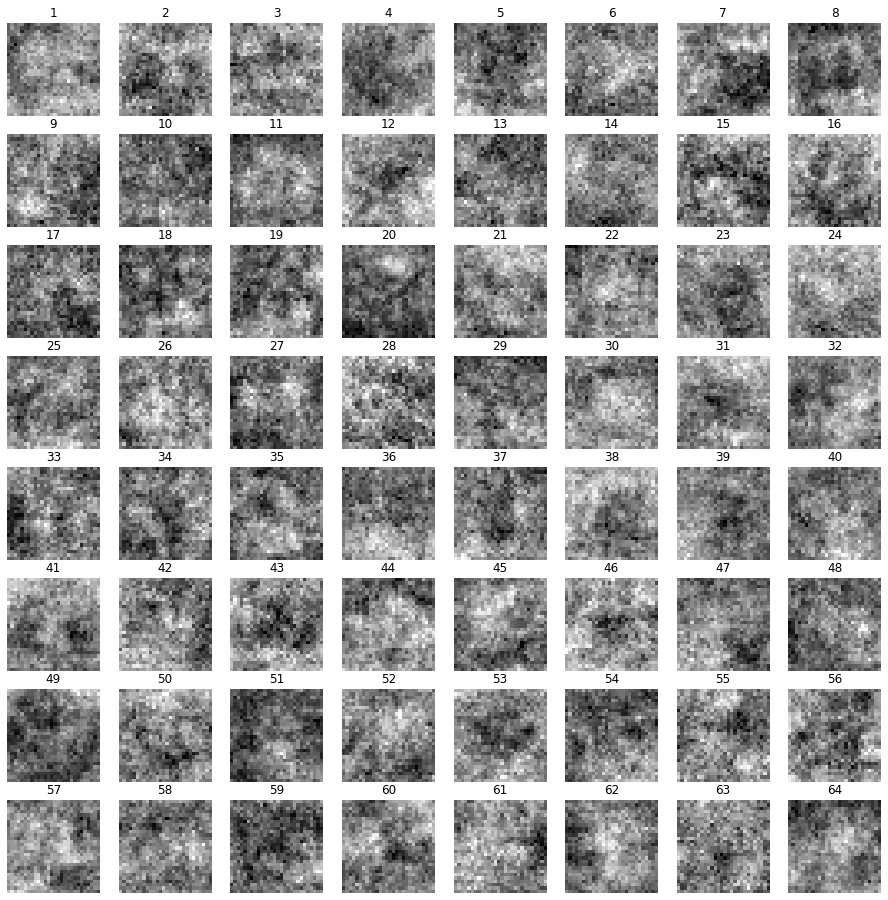

In [55]:
fig, axs = plt.subplots(8,8, figsize=(16, 16))
fig.subplots_adjust(hspace = .2, wspace=.001)

axs = axs.ravel()

for i in range(64):

    axs[i].imshow(model.V.detach().numpy()[i,...].reshape(28,28), cmap ="gray")
    axs[i].axis("off");
    axs[i].set_title(str(i+1))